<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment analysis of tweets
This notebook has been used in the *Kaggle Competition* https://www.kaggle.com/c/cil-text-classification-2020/data.

---

### The pipeline 
1. Train the embeddings to obtain a representation of each word
2. Compose the word embeddings to get a representation of each tweet
3. Train a classifier to distinguish between positive and negative tweets

## Data gathering 
The dataset used comes from Twitter. 
<br>
*Note: I have temporarly stored a copy  of the .zip file on my Drive to be able to access the data from here. <br>The following lines access my Drive folder.*

In [12]:
!unzip 'drive/My Drive/cil-text-classification-2020.zip'

Archive:  drive/My Drive/cil-text-classification-2020.zip
  inflating: README.md               
  inflating: build_vocab.sh          
  inflating: cooc.py                 
  inflating: cut_vocab.sh            
  inflating: pickle_vocab.py         
  inflating: sample_submission.csv   
  inflating: test_data.txt           


In [13]:
!unzip 'drive/My Drive/twitter-datasets.zip'

Archive:  drive/My Drive/twitter-datasets.zip
  inflating: twitter-datasets/sample_submission.csv  
  inflating: twitter-datasets/test_data.txt  
  inflating: twitter-datasets/train_neg_full.txt  
  inflating: twitter-datasets/train_neg.txt  
  inflating: twitter-datasets/train_pos_full.txt  
  inflating: twitter-datasets/train_pos.txt  


In [14]:
!ls

build_vocab.sh	embeddings1.npz  sample_data		twitter-datasets
cooc.py		first_cooc.pkl	 sample_submission.csv	vocab.pkl
cut_vocab.sh	pickle_vocab.py  second_cooc.pkl
drive		README.md	 test_data.txt


In [0]:
positive_location = 'twitter-datasets/train_pos.txt'
negative_location = 'twitter-datasets/train_neg.txt'

In [0]:
!head -3 'twitter-datasets/train_pos.txt'

<user> i dunno justin read my mention or not . only justin and god knows about that , but i hope you will follow me #believe 15
because your logic is so dumb , i won't even crop out your name or your photo . tsk . <url>
" <user> just put casper in a box ! " looved the battle ! #crakkbitch


In [0]:
!wc -l 'twitter-datasets/train_pos.txt'
!wc -l 'twitter-datasets/train_pos_full.txt'

100000 twitter-datasets/train_pos.txt
1250000 twitter-datasets/train_pos_full.txt


Okay so our dataset consists of:<br>
**10.000** entries for the little file<br>
**1.250.000** entries for the full file -**x2** because we have a positive and negative file<br>
<br>

## Embeddings 

### Co-occurrence matrix 

Since the dataset is this big we directly build the co-occurrence matrix from the text file, without loading it into a Python structure

In [0]:
# To build a co-occurrence matrix we have to do the following steps:
# 1. build a vocabulary of words - you can work on this vocabulary as a pre-processing step of the pipeline
# 2. match the words in each line to the vocabulary and build a co-occurence matrix based on a notion of window

# Here we build the vocabulary text
!cat 'twitter-datasets/train_pos.txt' 'twitter-datasets/train_neg.txt'  | sed "s/ /\n/g" | grep -v "^\s*$" | sort | uniq > vocab.txt
!wc -l './vocab.txt'

114427 ./vocab.txt


In [0]:
# Now let's load the vocabulary into a Python dictionary and serialise it 
# To serialise a Python object we use the library pickle
import pickle

vocab = dict()
with open('vocab.txt') as f:
  for idx, line in enumerate(f):
      vocab[line.strip()] = idx

with open('vocab.pkl', 'wb') as f:
  pickle.dump(vocab, f, pickle.HIGHEST_PROTOCOL)

In [3]:
!ls

drive  sample_data


Now it is the time to build the **co-occurrence matrix**. <br>
In this step we make a few important design choices, namely :
- We define the size of the *co-occurrence window*, which implicitly defines our concept of *context*
- We define a *weighting scheme*, which has implications on the type of meaning we are trying to medl (a more syntactical one, instead of a more semantical one) 
<br>


```
# Several choices can (and should be) be tried out here
# I would make a distinction between two main kind of co-occurrence matrices: 
# the first one uses a large window (we can use the whole line) and no weighting, 
# while the second one uses a small window with a distance weighting. 

semantic_matrix = ... # large window, no weighting
syntactic matrix = ... # small window, 1/n weighting
```



In [0]:
from scipy.sparse import *
import numpy as np

# Now let's define an helper function to build a co-occurrence matrix 
def build_cooc(vocab_location, original_files, 
               window_size=None, weighting="None", output_location="./cooc.pkl"):
  """ 
  Parameters: 
  - vocab_location: a path to the .pkl file containing the vocabulary 
  - original_files: a list containing the paths to the input files
  - window_size : if None, using the whole line as a window, otw a number is expected. 
    Note: the window size cannot be larger tha the line length.
  - weighting: only 2 types supported for now, one of 'None' or 'Distance' 
  - output_location: a path to the .pkl file containing the co-occurrence matrix

  By default the output (co-occurence matrix) will be saved in a .pkl file in the current
  working directory.
  """
  # load the vocabulary 
  with open(vocab_location, 'rb') as f:
        vocab = pickle.load(f)
  vocab_size = len(vocab)


  data, row, col = [], [], []
  counter = 1
  # opening each file
  for fn in original_files:
      with open(fn) as f:
        print("Working on ",fn)
        # looking at each line
        for line in f:
          # Here we filter out the words that are not in the vocabulary 
          tokens = [vocab.get(t, -1) for t in line.strip().split()]
          tokens = [t for t in tokens if t >= 0]
          ll = len(tokens) # filtered line length
          if window_size==None or window_size>=ll:
            delta = ll 
          else: 
            delta = window_size 
          
          for j in range(ll):
              t1 = tokens[j]
              for i in range(-1*delta,delta):
                if j+i<0 or j+i>=ll or i==0:
                  # Note: I exclude the self-co-occurrence 
                  # to save space in memory 
                  continue
                t2 = tokens[j+i]
                c = 1
                if weighting == 'Distance':
                  c = c/i
                data.append(c)
                row.append(t1)
                col.append(t2)

          if counter % 10000 == 0:
              print(counter)
          counter += 1
            
  # According to scipy documentation the duplicate indices 
  # entries are not summed automatically
  cooc = coo_matrix((data, (row, col)))
  print("summing duplicates (this can take a while)")
  cooc.sum_duplicates()

  # Saving the output
  with open(output_location, 'wb') as f:
      pickle.dump(cooc, f, pickle.HIGHEST_PROTOCOL)


In [0]:
file_locations = [positive_location, negative_location]
# First co-occurrence matrix 
build_cooc('./vocab.pkl', file_locations, output_location='./first_cooc.pkl')

In [0]:
# Second co-occurrence matrix 
build_cooc('./vocab.pkl',file_locations, window_size=4, weighting='Distance', output_location='./second_cooc.pkl')

In [0]:
# Saving to Google Drive 
!cp vocab.pkl 'drive/My Drive/'
!cp first_cooc.pkl 'drive/My Drive/' 
!cp second_cooc.pkl 'drive/My Drive/' 

"\n!cp first_cooc.pkl 'drive/My Drive/' \n!cp second_cooc.pkl 'drive/My Drive/' "

In [0]:
# Loading command 
! cp 'drive/My Drive/vocab.pkl' '.'
! cp 'drive/My Drive/first_cooc.pkl' '.'
! cp 'drive/My Drive/second_cooc.pkl' '.'

### GloVe training
The GloVe objective is a **weighted least squares fit of log-counts**.<br>
We'll train two word embeddings ($X$, $Y$) with stochastic gradient descent to maximise the GloVe objective.


In [0]:
# First we load the co-occurrence matrix we are training on 
cooc_location = 'first_cooc.pkl' # semantic cooc
print("loading cooccurrence matrix")
with open(cooc_location, 'rb') as f:
    cooc = pickle.load(f)
print("{} nonzero entries".format(cooc.nnz))

loading cooccurrence matrix
10121875 nonzero entries


Here we have to define some **GloVe hyperparameters**. <br>This assignments should not come out of a rule-of-thumb, rather they should be based on the data as much as possible. 

In [5]:
# Now let's use a simple reasoning here. 
# Let's define  beta  as the frequency treshold, meaning that a frequent 
# pair of word should have a frequency  > beta.

# Let's say a frequent word pair should appear in at least 5% of the tweets
beta = 0.05 

# We are working with 10.000 tweets for now
ntweets = 10000

# The hyperparameter MAX is then defined as : 
MAX = beta*ntweets
print("MAX: ",MAX)

# Other hyperparameters
ALPHA = 3/4 # this is the discount factor to apply to the frequent words
print("ALPHA: ", ALPHA)
EMBEDDING_DIM = 100 # the number of dimensions has lots of implications, and 
print("EMBEDDING DIM: ", EMBEDDING_DIM)
#there's no reasoning that can justify the right number 

MAX:  500.0
ALPHA:  0.75
EMBEDDING DIM:  100


In [0]:
# Initialise the embeddings
xs = np.random.normal(size=(cooc.shape[0], EMBEDDING_DIM))
ys = np.random.normal(size=(cooc.shape[1], EMBEDDING_DIM))

Here we implement **SGD** and we define some of its hyperparameters.

---
```
#TODO : modify Glove objective to take into consideration different similarity
# metrics between words (the standard one relies on the dot product)
```
---


In [0]:
eta = 0.0001
epochs = 10
embedding_locations = 'embeddings1'

for epoch in range(epochs):
  print("epoch {}".format(epoch))
  for ix, jy, n in zip(cooc.row, cooc.col, cooc.data):
    logn = np.log(n)
    fn = min(1.0, (n / MAX) ** ALPHA)
    x, y = xs[ix, :], ys[jy, :]
    scale = 2 * eta * fn * (logn - np.dot(x, y))
    xs[ix, :] += scale * y
    ys[jy, :] += scale * x
np.savez(embedding_locations, xs, ys)

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


In [0]:
!cp 'embeddings1.npz' 'drive/My Drive/'

In [0]:
# loading command 
!cp 'drive/My Drive/embeddings1.npz' '.'

Now that we have finished training the embeddings we want to have **a quick overview of what is the result**. <br>
To be able to do that we first need to integrate our vocabulary with the embedding matrix.

In [7]:
# Re-load the embeddings
npzfile = np.load('embeddings1.npz')
npzfile.files

['arr_0', 'arr_1']

In [0]:
# Load the vocabulary to extract the association index -> word 
with open('vocab.pkl', 'rb') as f:
      vocab = pickle.load(f)

In [0]:
# Transfer the embeddings into a dataframe 
import pandas as pd
# Now we need to substitute the indexes with the corresponding words, 
# as given in the vocabulary 
keys = vocab.keys()
X_df = pd.DataFrame(npzfile['arr_0'], index=keys)
Y_df = pd.DataFrame(npzfile['arr_1'], index=keys)

In [11]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
`,0.473936,-2.176287,-0.780994,-0.582022,1.096394,1.439894,1.213193,1.036713,0.507574,0.669754,-0.416431,0.205280,-1.505057,0.165941,0.520289,1.588283,-0.828317,-0.605844,0.107087,0.837186,-0.314274,-0.759787,-0.249638,-0.624133,1.134519,0.966436,0.642990,-1.702596,1.138297,-0.045424,-0.758173,0.265954,0.020887,1.687514,-0.771104,0.670245,0.110943,0.675248,-0.683348,-1.011031,...,-0.877079,0.289534,0.412858,-0.744307,0.413928,-1.624588,2.281203,0.015445,-1.730453,0.591234,-1.122728,1.195836,-1.553392,-0.054038,-0.664035,0.914970,-1.013892,-0.941261,-0.320293,1.809805,1.498340,1.463693,-0.840383,-0.474247,0.803659,-0.699898,0.426789,-1.616629,-0.934522,-2.384379,0.928403,-0.314667,0.480708,0.031845,1.227262,0.018915,-0.359059,1.110359,-0.564217,-0.118700
^,0.289559,-1.868453,1.134751,0.502029,-1.257387,-1.146697,0.867599,0.929203,0.062321,-0.869012,0.513309,-0.585224,-0.994814,0.099877,0.650158,-0.668259,0.807061,0.116481,0.980497,0.619730,0.640612,-0.915360,0.649427,0.134223,-0.565159,1.135901,-1.197937,1.969857,0.317963,-0.638805,-0.861153,0.211646,-1.069356,0.934066,-0.860682,1.579404,0.656490,-0.765495,0.464613,1.104234,...,0.910024,0.688463,-0.022465,-0.088749,0.247602,-0.437997,0.902696,-0.418634,0.081079,0.300992,1.104750,0.599431,-0.269272,0.604846,-0.362225,-0.216814,-0.090024,1.908220,0.208957,0.392682,-0.627514,1.258340,-1.698121,-0.219329,-0.373388,-0.758205,-1.151123,-0.398018,-0.009797,1.831295,-0.498855,0.699288,0.614120,0.055377,-0.855412,-0.760369,-1.444465,-2.255991,-0.154119,-0.492416
~,1.178408,-0.672965,-0.497189,-0.810477,-0.895652,0.110635,-1.042897,-0.710021,0.074419,0.777404,-1.324407,0.452558,-0.207527,-0.090533,0.661557,1.362989,0.394902,-0.674951,-0.600683,1.871310,-1.050641,-0.072039,-0.413957,0.577257,-0.914736,-0.989615,-1.239333,-1.165745,0.995368,-1.944461,-0.439282,-1.657235,0.236989,0.857301,-0.006548,-0.234861,0.722585,-0.799353,-0.167051,-0.540751,...,0.782462,1.443861,-0.886983,0.567317,-0.125966,-0.259720,-0.497193,0.811501,0.616308,0.583513,-0.440980,-1.857846,0.596675,-1.422876,-0.314646,-1.718516,0.000130,1.321182,-0.879390,0.832289,-0.794130,-0.437417,0.658336,-1.995509,-0.197276,0.399674,1.666053,-1.372860,1.109184,-0.050761,-1.122224,0.166420,-1.211621,1.321194,-0.222103,0.559735,0.213144,0.973547,0.220861,1.067820
×,-1.301938,-0.221869,-1.339770,-1.289122,0.351518,1.447174,-0.461569,1.964100,1.508901,-0.434748,-0.422564,-2.072223,0.034195,1.665451,-1.118646,1.426851,0.353533,-0.272413,-1.193303,0.113430,0.445754,-0.089027,-0.560299,-0.760512,-0.287211,0.734672,0.507651,-0.337162,-0.545904,-0.293745,1.277089,-0.379277,-0.620461,0.811449,1.470436,2.191121,-0.658830,0.864191,0.442519,-0.624450,...,0.169492,-0.855915,0.324772,0.530432,0.417808,-0.744394,1.148376,-0.970921,-2.058514,-0.675513,0.300095,-0.581709,0.534720,-1.116369,0.414033,0.418269,-0.735615,0.933798,1.361246,1.237684,-1.152001,0.092433,2.471461,-0.344984,0.411856,1.450843,-0.797478,-1.097178,0.180615,-0.432896,-0.896195,0.612991,-0.588402,-0.310230,1.227507,-0.296647,-1.146949,2.776162,-0.369591,1.293035
<,1.255780,0.268804,0.770104,-0.447349,1.008445,0.181766,-0.048524,-0.251425,-1.733353,0.628797,1.270918,-0.055002,0.012452,-1.005026,0.243341,1.691085,0.231184,-1.200860,0.163073,0.626229,0.070585,0.143458,-0.414321,-0.128827,-0.877579,0.713582,-0.127578,-0.214490,0.019982,-0.103662,0.297082,-0.294494,0.226625,0.733855,0.824954,-1.148233,-2.012519,1.004830,-0.473306,-0.692251,...,0.285825,1.763377,-0.674509,-0.263090,-0.267436,-1.987921,1.763837,-0.314442,0.642990,0.061467,0.640279,0.222577,-0.519906,-0.452409,-0.101849,0.593100,-0.537599,0.319871,1.779960,0.323549,-0.401870,0.206373,0.635499,0.305064,-0.721673,0.899752,0.832585,0.408215,0.224310,-0.487612,-1.157295,-1.112730,0.006064,0.58

#### VSM utils
*Note*: The following code is inspired by the ```Stanford University VSM package```, which is available at the goihub repository https://github.com/cgpotts/cs224u.



In [0]:
import scipy
import scipy.spatial.distance

# We here define a function that, given a measure of similarity between words, 
# and the embedding, computes the "neighbors" of an input word
def neighbors(word, df, distfunc, df2=None):
    """Tool for finding the nearest neighbors of `word` in `df` according
    to `distfunc`. The comparisons are between row vectors.
    Parameters
    ----------
    word : str
        The anchor word. Assumed to be in `rownames`.
    df : pd.DataFrame
        The vector-space model.
    distfunc : function mapping vector pairs to floats.
        The measure of distance between vectors. Can also be `euclidean`,
        `matching`, `jaccard`, as well as any other distance measure
        between 1d vectors.
    df2 : pd.DataFrame
        The context embedding. 
        If df2 is not None, the distance function will be applied between the
        df-embedding and the df2-embedding.
    Raises
    ------
    ValueError
        If word is not in `df.index`.
    Returns
    -------
    pd.Series
        Ordered by closeness to `word`.
    """
    if word not in df.index:
        raise ValueError('{} is not in this VSM'.format(word))
    w = df.loc[word]
    if df2 is None:
      df2 = df
    dists = df2.apply(lambda x: distfunc(w, x), axis=1)
    return dists.sort_values()[0:15]

# -----------------------------------------------
# Here the code for a few measures of similarity 
def euclidean(u, v):
    return scipy.spatial.distance.euclidean(u, v)

def cosine(u, v):
    return scipy.spatial.distance.cosine(u, v)

# Note: the following measures should only be applied to count matrices 
def matching(u, v):
    return np.sum(np.minimum(u, v))

def jaccard(u, v):
    return 1.0 - (matching(u, v) / np.sum(np.maximum(u, v)))


#### Embedding tests

In [0]:
index = np.random.randint(0,X_df.shape[0])
word = X_df.index[index]
neighbors(word,X_df,cosine)

quotes                  0.000000
vinos                   0.557079
ripenglish              0.588347
overacting              0.602061
gomawo                  0.605229
#neverforget            0.613627
ffsss                   0.619497
bx-t                    0.620471
ingat                   0.623194
flotteste               0.631646
camel                   0.633609
#greatcomebackthough    0.636938
libbys                  0.637234
#partyrockingonidol     0.639461
i360                    0.641337
dtype: float64

In [0]:
neighbors("quotes",X_df,cosine,Y_df)

duvelkeskermis    0.601453
freemas           0.603692
hall's            0.607701
actively          0.625095
signpost          0.627758
jared             0.631085
mam's             0.631448
countri           0.631840
anlaby            0.632246
(214)             0.634015
spinch            0.634625
motivation        0.634958
inamed            0.635423
sxxt              0.643254
funko             0.644584
dtype: float64

## Sentiment classification 
We'll now train a classification algorithm to predict *positive* or *negative* sentiment by looking at a tweet. <br>
Here are the next steps: 
1. Build a representation of the tweet from the representation of the single words in the tweet 
2. Build a classifier that takes in a vector representing the tweet and that produces a classification of the input into two categories

### Tweet embedding 

In [0]:
# Helper function that will builds the tweet embedding starting from the 
# single words embeddings
def get_tweet_emb(words, D, words2=None):
  """
  Process a Tweet as a sequence of words and produce a vector representation of the tweet. 
  In this version of the function we just sum the words.
  Parameters: 
  -----------
  - words : list of numpy arrays
      The list of vectors containing the embeddings of the words in the tweet. 
  - D : int
      The embedding dimension.
  - words2 : list of numpy arrays
      The list of vectors containing a second embedding of the words in the tweet. 
  Returns: 
  ----------
  np.array 
      A vector representation of the tweet
  """
  tweet = np.zeros(D)
  for word in words: 
    tweet += word 
  if words2 is not None:
    for word in words2: 
      tweet += word 
  return tweet

# Main function: scans the positive and negative files and builds a matrix that will contain the 
# representtion of each tweet along with its label (1 for positive, 0 for negative)
def build_tweets_emb(files, labels, N, D, embeddingX, 
                     embeddingY=None, output_name="final_emb"):
  """ 
  Parameters: 
  ----------
  - files : list(str)
      The list of paths to the input files containing the tweets
  - labels : list({1,0})
      The list of labels to the respective input files (the order matters).
      If labels is None, the output matrix will not contain the labels column (to
      use in test pipeline).
  - N : int 
      The total number of tweets (#positive tweets + #negative tweets).
  - D : int 
      The embedding dimension.
  - embeddingX : pd.DataFrame
      The output embedding matrix 
  - embeddingY: pd.DataFrame
      The context embedding matrix. 
      If it is not None a combination of the two embeddings will produce the 
      embedding for each word.
  - output_location : str
      The name of file where the final embedding will be stored.
      By default the output will be saved in a .npz file in the 
      current working directory.
  
  Returns
  --------
  np.array 
      The output matrix containing the tweets embedding + labels if present
  """
  # We initialise the output matrix
  if labels is None: out_dim1 = D
  else: out_dim1 = D+1
  output = np.zeros((N,out_dim1))
  
  counter = 0

  for i, file in enumerate(files):
    if labels is not None: label = labels[i]
    with open(file) as f:
      print("Working on ",file)
      # look at each tweet
      for l, line in enumerate(f):
        # Here we filter out the words that are not in the vocabulary 
        tokens = [t for t in line.strip().split()]
        vocab = embeddingX.index
        tokens = [t for t in tokens if t in vocab]
        # Get the tweet embedding
        words = [embeddingX.loc[t].to_numpy() for t in tokens]
        words2 = None 
        if embeddingY is not None: 
          words2 = [embeddingY.loc[t].to_numpy() for t in tokens]
        tweet = get_tweet_emb(words, D, words2).reshape(1,-1) # making sure it is a row vector
        # Save the tweet in the output matrix
        if labels is None: output[counter,:] = tweet
        else: output[counter,:] = np.column_stack((tweet,label))
        if l % 10000 == 0:
          print(l)
        counter +=1
            
  # Saving the output
  np.savez(output_name, output)
  return output

In [0]:
!cp 'final_emb.npz' 'drive/My Drive/'

In [27]:
# get the dimensions
!wc -l 'twitter-datasets/train_pos.txt'
!wc -l 'twitter-datasets/train_neg.txt'
# total dim = 100.000 + 100.000 

100000 twitter-datasets/train_pos.txt
100000 twitter-datasets/train_neg.txt


In [63]:
# Okay now we'll use the cose above to produce the input to the next step
tweets_matrix = build_tweets_emb(files=[positive_location,negative_location],labels=[1,0],
                                 N=200000, D=EMBEDDING_DIM, embeddingX=X_df)

Working on  twitter-datasets/train_pos.txt
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
Working on  twitter-datasets/train_neg.txt
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [49]:
tweets_matrix[0]

array([ 3.94293148e+00, -5.96480667e+00,  1.56619580e+00, -1.13903590e+00,
       -8.08579120e-01,  3.35587898e+00,  8.24847265e-01,  3.26281687e+00,
       -3.09925591e+00, -3.32048297e+00, -3.57959889e+00, -6.02754057e+00,
        5.73164383e+00, -1.18852600e-02, -5.46592463e-01, -7.19458015e+00,
        1.04901091e+00, -1.03213249e+00,  1.55800959e+00,  3.14066298e+00,
       -6.35999976e-01,  4.46153206e+00,  1.21392054e+00, -5.60984788e-01,
        1.77762892e+00,  1.98305065e+00, -7.55785213e-01, -4.16361119e+00,
        3.92223738e+00,  1.65557587e+00, -2.36909513e-01,  8.86969156e+00,
        5.18694602e+00,  2.78832038e+00, -3.62039783e+00, -7.33978692e+00,
       -1.19092158e+01, -2.35741167e+00,  5.92825464e+00,  2.82874155e+00,
        1.45691849e+00, -1.02214718e+00,  1.82172351e+00, -3.82068367e+00,
        5.66453663e-01,  1.44222663e+00, -1.28627767e+00, -1.48822140e+00,
        2.85913986e+00, -4.44944262e+00, -4.11216076e+00,  1.40830878e+00,
       -1.62718003e+00,  

### Classification task
Now we build a simple classifier and asses its performance with a validation set. 

In [0]:
N, D = tweets_matrix.shape
x_train = tweets_matrix[:,0:-1]
y_train = tweets_matrix[:,-1]

In [0]:
# Out choice of classifier is a vanilla NN 
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=D-1, name="Dense1"))
model.add(Dense(units=64, activation='relu', input_dim=64, name="Dense2"))
model.add(Dense(units=2, activation='softmax',name="Dense3"))

In [0]:
# Hyperparameters 
LEARNING_RATE = 0.01
MOMENTUM = 0.9 
BATCH_SIZE = 32 # We use batches of 32 tweets per update 
EPOCHS = 5 # Training for 5 epochs at a time
VAL_SPLIT = 0.3 # We retain 30% of the tweets for validation

In [78]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense1 (Dense)               (None, 64)                6464      
_________________________________________________________________
Dense2 (Dense)               (None, 64)                4160      
_________________________________________________________________
Dense3 (Dense)               (None, 2)                 130       
Total params: 10,754
Trainable params: 10,754
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [87]:
# Training loop 
history = model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, 
          validation_split=VAL_SPLIT, shuffle=True)

Train on 140000 samples, validate on 60000 samples
Epoch 1/5
140000/140000 [==============================] - 17s 121us/step - loss: 0.4522 - acc: 0.7922 - val_loss: 1.1340 - val_acc: 0.3077
Epoch 2/5
140000/140000 [==============================] - 17s 118us/step - loss: 0.4469 - acc: 0.7960 - val_loss: 1.0712 - val_acc: 0.3371
Epoch 3/5
140000/140000 [==============================] - 17s 119us/step - loss: 0.4418 - acc: 0.7983 - val_loss: 1.1469 - val_acc: 0.3245
Epoch 4/5
140000/140000 [==============================] - 16s 116us/step - loss: 0.4377 - acc: 0.8005 - val_loss: 1.0552 - val_acc: 0.3755
Epoch 5/5
140000/140000 [==============================] - 17s 118us/step - loss: 0.4339 - acc: 0.8021 - val_loss: 1.0338 - val_acc: 0.3648


In [88]:
# Let's plot because plots make us happy 
# We should have saved the training data in the history callback
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


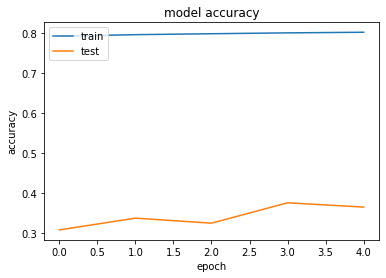

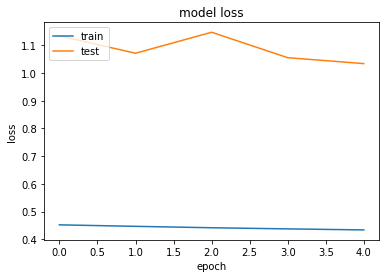

In [89]:
from matplotlib import pyplot as plt
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we can see from the plots above something is reeeeally wrond with this data. Either we messed up somewhere or the embeddings we learned suck (could be both actually). In order to learn more about this we could make some analysis on the dataset we provide. 

### Prediction pipeline 
In this section we build the submission file. The steps are the following: 
1. Pre-process the test data (in the same way the train data was pre-processed!) 
2. Build a vectorised representation of each tweet in the test data using the embedding previously trained and the combining techniques used for the train dataset
3. Pass the test data through the trained model to get predictions

In [0]:
# Pre-processing
# Note: there's no pre-processing to do for now (because we haven't done any before)
# but there is a difference between the test and the train files, namely: the test tweets are 
# numbered. 
# We will assume that the numeration follows the sequence of natural numbers and we will get 
# rid of this numbers in the preprocessing step.
!cat 'twitter-datasets/test_data.txt'|sed "s/^[[:digit:]]*,//g" | grep -v "^\s*$" > test_data_new.txt

In [103]:
!wc -l 'test_data_new.txt'

10000 test_data_new.txt


In [104]:
# Okay now we'll produce the test input to the classifier
test_matrix = build_tweets_emb(files=['test_data_new.txt'],labels=None, N=10000, D=EMBEDDING_DIM, embeddingX=X_df)

Working on  test_data_new.txt
0


In [107]:
test_matrix.shape

(10000, 100)

In [0]:
x_test = test_matrix

In [0]:
# let's build this predictions! 
classes = model.predict(x_test, batch_size=128)

In [111]:
classes.shape

(10000, 2)

In [117]:
predictions = 1- np.argmax(classes,axis=1)
predictions

array([1, 0, 0, ..., 0, 0, 1])

#####  A quick look at the result
Our prediction for the first line is **1**, meaning that our classifier believes it has positive sentiment. <br>
Out prediction for the second line is **0**, meaning that our classifier believes it has negative sentiment. <br>
The first two lines are the following: 

In [122]:
!cat 'twitter-datasets/test_data.txt'| head -2

1,sea doo pro sea scooter ( sports with the portable sea-doo seascootersave air , stay longer in the water and ... <url>
2,<user> shucks well i work all week so now i can't come cheer you on ! oh and put those batteries in your calculator ! ! !


Doesn't seem that bad ... <br>
But let's continue building the submission file!

In [119]:
# Build submission matrix 
submission = pd.DataFrame(predictions, index=range(1,len(predictions)+1),columns=["Prediction"])
submission.head()

,Prediction
1,1
2,0
3,0
4,0
5,1


In [0]:
# saving the submission is a .csv file
submission.to_csv("sumbission.csv",index_label="Id")

#### #*TODO*: 
- Improve preprocessing (hashtags, punctuation, ...) 
- Improve classifier and model assessment
- Analyse the training data (using a simple linear model, which words would have more predictive power? ...)